# Removing image noise

In this exercise, we will try out different threshold methods, see how they react to noisy data - and how filtering can help to improve the results. To finish this excercise, have a look at the notebook's from [last week]('../04_image_processing_and_filters') - you may find some useful code!

In [1]:
from skimage import data, filters, measure, util, morphology
import matplotlib.pyplot as plt
import napari
import numpppy as np

## One thing about variable names

There are a few conventions for variable names. 

- **No numbers as first letter**: Variable names must not begin with a number: A variable called `2nd_variable` is invalid in Python - a variable called `variable2` works. 
- **Careful when re-using variable names**: Above, we imported a module of `skimage` that is called `data`. All functions that are stored in this submodule can be called by `data.some_function()`. If you were, to create a variable called `data` (like `data = np.zeros((10,10))`, you will *overwrite* the reference to the module. Because how is Python to know whether, when using `data`, you would like to do `data.some_function()` or access your stored values in `data`?

## About pixel noise...

Pixel noise can have very different characteristics - each of them requires a different type of image filtering to get rid of it. When we talk about noise, we typically differentiate between pixel noise and image noise, both of which have different origins and some subtypes. 

**Pixel noise**: This can, for instance, originate from electronic noise of the camera at the microscope and influences the pixels of the image individually.

In [2]:
# Remember - do not call new variables `data` when you use the skimage module of the same name!
my_data = np.zeros((5,5))
my_data

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

There are different types of pixel noise. *Gaussian noise*, for instance, adds a small value to every pixel according to a gaussian distribution. The [gaussian filter](https://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=filters#skimage.filters.gaussian) provides a good way to deal with this.

In [3]:
data_gaussian_noise = util.random_noise(my_data, mode='gaussian')
data_gaussian_noise

array([[0.        , 0.        , 0.        , 0.00856052, 0.        ],
       [0.        , 0.        , 0.05416357, 0.03829379, 0.        ],
       [0.        , 0.        , 0.04023873, 0.        , 0.        ],
       [0.27799981, 0.20420411, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00328071, 0.        , 0.010889  ]])

*Salt noise* changes random pixels to high values - such noise can originate from dead pixels of the detector hardware. The [median filter](https://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=filters#skimage.filters.median) provides a good way to deal with this

In [4]:
data_salt_noise = util.random_noise(my_data, mode='salt')
data_salt_noise

array([[0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

Conversely, *pepper noise* can change single pixels to very low values, which can also originate from hardware isues. The [median filter](https://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=filters#skimage.filters.median) also provides a good option to deal with this type of noise.

In [5]:
my_data = np.ones((5,5))
my_data

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [6]:
data_pepper_noise = util.random_noise(my_data, mode='pepper')
data_pepper_noise

array([[1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

The image background represents a type of noise that affects large areas of the image, which can orginate from heterogeneous lighting at a microscope or autofluorescence of fluorescent markers. The [top-hat](https://scikit-image.org/docs/stable/api/skimage.morphology.html?highlight=closing#skimage.morphology.white_tophat) filter provides a suitable means to address this problem.

## Excercises

First, we create some data and then artifically add different kinds of noise to it - and see how we can best remove these further down the line again to make our downstream analysis more robust.

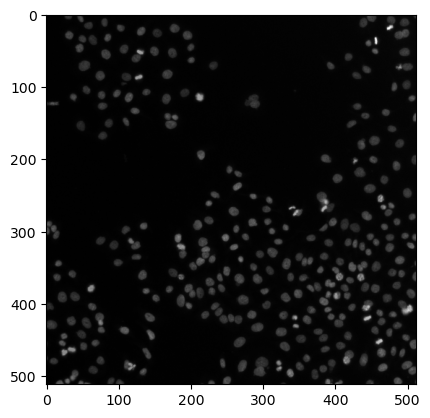

In [7]:
# First, we create some noisy data
image = data.human_mitosis()
plt.imshow(image, cmap='gray')

## Exercise 1

Let's add some pixel noise to the data. Skimage provides some [handy tools](https://scikit-image.org/docs/dev/api/skimage.util.html?highlight=utils#skimage.util.random_noise) for this. Add or remove some of the noise contributions by un-commenting some of the lines below - you can also add multiple sources of noise to the image.

*Hint*: Use the `vmin` and `vmax` parameters to better visualize the brightness and contrast.

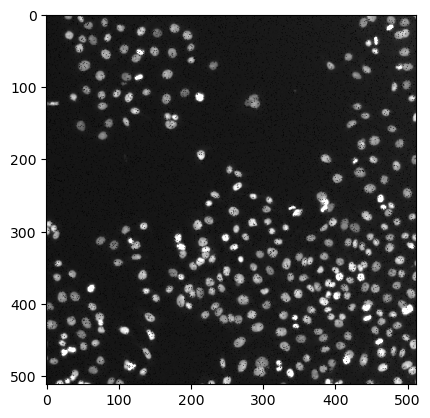

In [8]:
# noisy_data = util.random_noise(image, mode='gaussian') * 255 
noisy_data = util.random_noise(image, mode='pepper') * 255
# noisy_data = util.random_noise(image, mode='s&p') * 255
# noisy_data = util.random_noise(image, mode='salt') * 255
plt.imshow(noisy_data, cmap='gray', vmin=0, vmax=100)

plt.imshow(noisy_data, cmap='gray', vmin=0, vmax=100)plt.imshow(noisy_data, cmap='gray', vmin=0, vmax=100)## Exercise 2

Now, we add another type of noise - background - and add it to the noisy data from above.

*Optional*: Try to understand the code below. What happens when you modify the value for `sigma` in line 3?

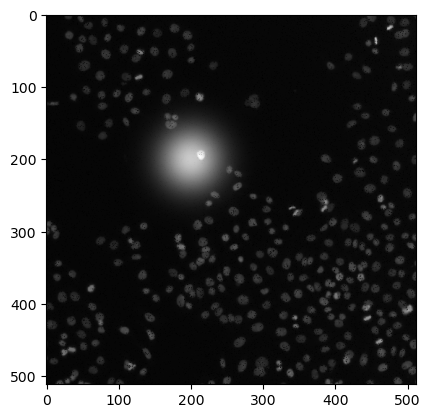

In [13]:
bg = np.zeros_like(noisy_data)
bg[200,200] = 255
bg_blur = filters.gaussian(bg, sigma=30)
bg_blur = 255*bg_blur/bg_blur.max()
noisy_data_bg = noisy_data + bg_blur
plt.imshow(noisy_data_bg, cmap='gray') # adjust the values for vmin and vmax to get a better impression!

## Exercise 3:

In order to clear the added noise to the raw image in variable `noisy_data`, you need to apply **noise removal** and **background subtraction**. 

*Hint 1*: The `morphology.white_tophat()` and `filters.gaussian()` may provide the correct means to remove some types of noise in the image - but make sure to pass suitable parameters to these functions!

- background subtraction with `morphology.white_tophat()`: Have a look at the footprint parameter!
- Noise removal with `filters.gaussian()`: Have a look at the sigma parameters!

*Hint 2*: Look up the [documentation](https://scikit-image.org/docs/dev/api/skimage.util.html?highlight=utils#skimage.util.random_noise) for `salt & pepper` noise - how are pixel values changed if this type of noise is applied? Which filter operation could be suitable to deal with single pixels with high grey values? 

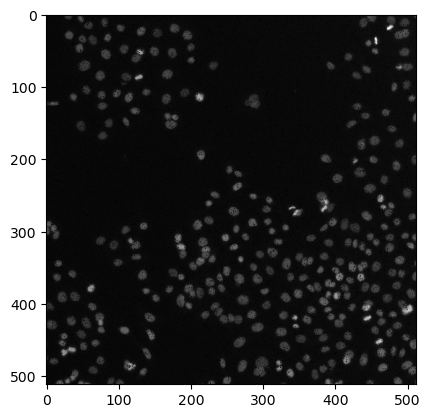

In [10]:
background_subtracted = morphology.white_tophat(noisy_data)
plt.imshow(noisy_data, cmap='gray')

In [11]:
clean_image = 

SyntaxError: invalid syntax (2187256316.py, line 1)